Render sphere at position; posture camera, and ensure we have the same setup
(coordinate, projects, etc.) as Drake.

Using images + settings from:
https://nbviewer.jupyter.org/github/EricCousineau-TRI/repro/blob/b0fc5a7/drake_stuff/notebooks/sphere_rendering.ipynb

In [1]:
import dataclasses as dc
import os

import torch
import numpy as np
from PIL import Image
import tqdm

import neural_renderer as nr
from simple_mesh import Mesh, make_fake_textures, intrinsic_matrix_from_fov

In [2]:
np.set_printoptions(formatter={"float_kind": lambda x: f"{x:,.4f}"})

In [3]:
torch.set_grad_enabled(False)
device = torch.device("cuda")
dtype = torch.float32

In [4]:
example_dir = ".."
mesh_dir = os.path.join(example_dir, 'data')

In [5]:
I3 = np.eye(3)
R_z90 = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1],
])

In [6]:
@dc.dataclass
class Setup:
    p_WC: np.ndarray
    R_WC: np.ndarray

In [7]:
width = 128
height = 128
fov_y = np.pi / 4
K = intrinsic_matrix_from_fov(width, height, fov_y)
print(K)
K = torch.from_numpy(K).to(device, dtype).unsqueeze(0)

[[154.5097 0.0000 63.5000]
 [0.0000 154.5097 63.5000]
 [0.0000 0.0000 1.0000]]


In [8]:
z = -10.0
setups = [
    Setup([0, 0, z], I3),
    Setup([1, 0, z], I3),
    Setup([0, 1, z], I3),
    Setup([0, 0, z], R_z90),
]

# Renders corresponding to above camera positions.
drake_image_files = [
    "./pyramid_render_0.png",
    "./pyramid_render_1.png",
    "./pyramid_render_2.png",
    "./pyramid_render_3.png",
]

In [9]:
# load template once.
template_file = os.path.join(mesh_dir, 'pyramid_lowpoly.obj')
# Postured at origin.
scene = Mesh.from_file(template_file)

# create renderer
assert width == height
renderer = nr.Renderer(
    camera_mode='projection',
    projection_left_hand=False,
    image_size=width,
    light_direction=[0, 0, -1],
    light_intensity_directional=0.5,
)

In [10]:
def estimate_mask(rgb):
    bg = rgb[0, 0, :]
    return (rgb == bg).all(axis=2)

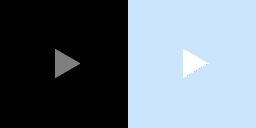

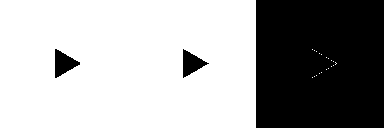


---



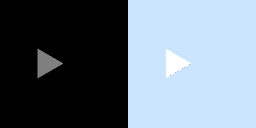

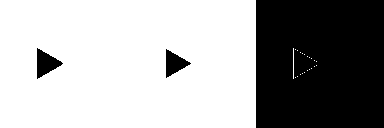


---



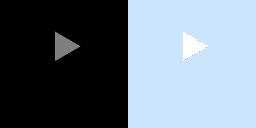

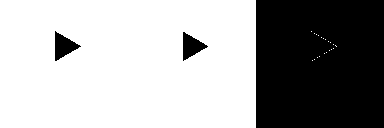


---



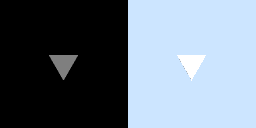

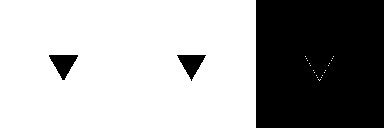


---



In [11]:
for i, setup in enumerate(setups):
    # NumPy.
    p_WC = np.asarray(setup.p_WC)
    R_WC = np.asarray(setup.R_WC)
    
    # Invert.
    R_CW = R_WC.T
    p_CW = -R_CW @ p_WC

    # torch.
    vertices, faces = scene.unsqueeze()
    fake_textures = make_fake_textures(faces)
    p_CW = torch.from_numpy(p_CW).to(device, dtype).unsqueeze(0)
    R_CW = torch.from_numpy(R_CW).to(device, dtype).unsqueeze(0)

    images = renderer.render_rgb(
        vertices,
        faces,
        textures=fake_textures,
        R=R_CW,
        t=p_CW,
        K=K,
    )
    image = images.squeeze(0)

    # Save image.
    rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
    rgb = (rgb * 255).astype(np.uint8)
    mask = estimate_mask(rgb)

    drake_rgb = Image.open(drake_image_files[i])
    drake_rgb = np.asarray(drake_rgb)
    drake_rgb = drake_rgb[:, :, :3]  # remove alpha channel
    drake_mask = estimate_mask(drake_rgb)
    
    diff_mask = mask != drake_mask
    
    rgb_stacked = np.concatenate([rgb, drake_rgb], axis=1)
    display(Image.fromarray(rgb_stacked))
    mask_stacked = np.concatenate([mask, drake_mask, diff_mask], axis=1)
    display(Image.fromarray(mask_stacked))
    print("\n---\n")